NOTES
- PCA Doesn't help much
        multipath, no_poly, no PCA     
- Mult-path worth .02
        - single path/no_poly/PCA_all  0.7176
        - multi path / no_poly/PCA_all 0.7368
- POLYGONS don't seem to help  - same performance
        -multi path /poly / PCA_all 


Mediapipe Specs
https://google.github.io/mediapipe/solutions/pose.html 


<img src="http://drive.google.com/uc?export=download&id=1nSdlOv09Isye_wtDIfHQlrJbhPqWhx3M" width="400">

<img src="http://drive.google.com/uc?export=download&id=1nW9OZDMGXQEv_KHRPJ5SveOjLP0O_CfA" width="400">



Face
https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Jupiter  MacOS
# BASE_DIR = "/Users/johnhanratty/Library/CloudStorage/OneDrive-Personal/IRMA_GIT/Kaggle_SignLanguage/asl-signs"
# WORKING_DIR = BASE_DIR
# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
WORKING_DIR = "/content/asl-work"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working/"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 24 # 16
PTS_IN_FRAME = 115
DIMC = [0,1,2]
DIMS = len(DIMC)

  
HANDIDX = {"WRIST":0, "THUMB_CMC":1, "THUMB_MCP":2,     "THUMB_IP":3,          "THUMB_TIP":4,
        "INDEX_FINGER_MCP":5, "INDEX_FINGER_PIP":6,  "INDEX_FINGER_DIP":7,  "INDEX_FINGER_TIP":8,
        "MIDDLE_FINGER_MCP":9,"MIDDLE_FINGER_PIP":10,"MIDDLE_FINGER_DIP":11,"MIDDLE_FINGER_TIP":12,
        "RING_FINGER_MCP":13, "RING_FINGER_PIP":14,  "RING_FINGER_DIP":15,  "RING_FINGER_TIP":16,
        "PINKY_FINGER_MCP":17,"PINKY_FINGER_PIP":18,  "PINKY_FINGER_DIP":19,"PINKY_FINGER_TIP":20}

POSEIDX = {"NOSE":0,        "LEFT_EYE_INNER":1,"LEFT_EYE":2,   "LEFT_EYE_OUTER":3, "RIGHT_EYE_INNER":4, "RIGHT_EYE":5,      "RIGHT_EYE_OUTER":6,
        "LEFT_EAR":7,    "RIGHT_EAR":8,     "MOUTH_LEFT":9, "MOUTH_RIGHT":10,   "LEFT_SHOULDER":11,  "RIGHT_SHOULDER":12,
        "LEFT_ELBOW":13, "RIGHT_ELBOW":14,  "LEFT_WRIST":15, "RIGHT_WRIST":16, 
        "LEFT_PINKY":17, "RIGHT_PINKY":18,  "LEFT_INDEX":19,"RIGHT_INDEX":20,   "RIGHT_THUMB":21,    "LEFT_THUMB":22,
        "LEFT_HIP":23,   "RIGHT_HIP":24,    "LEFT_KNEE":25, "RIGHT_KNEE":26,    "LEFT_ANKLE":27,     "RIGHT_ANKLE":28,
        "LEFT_HEEL":29,  "RIGHT_HEEL":30,   "LEFT_FOOT_INDEX":31, "RIGHT_FOOT_INDEX":32}

LIPSIDX = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
LIPSIDX_sm = [185, 39, 0,  269,  409,  78,  80,  82,  312,  310,  308,  88,  87,  317,  318,  146,  181,  17,  405, 375]


# need to rerun parquet processing to grab data points
#LIPSIDX1 = [12, 268,271,272,407, 293, 325,319,403,316,15,86,179,89,96,62, 183,42,41,38]

METALEN = len(LIPSIDX) + len(POSEIDX) + 2 * len(HANDIDX)

def PRIM_HAND(idx): return(40 + HANDIDX[idx])
def POSE(idx):  return(40 + 21 + POSEIDX[idx])
def SEC_HAND(idx):  return(40 + 21 + 33 + HANDIDX[idx])

print(POSE("NOSE"))
print(SEC_HAND("WRIST"))
METALEN

print('done')


61
94
done


In [5]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



In [6]:
# PREPOCESS-A  - FRAMES OUTPUT
import psutil

def preProc():
  dx = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
  datay = np.load(f"{WORKING_DIR}/feature_labels.npy") 

  data_rows = dx.shape[0]

  print("DX BASE", dx.base)   #BASE1 ROOT READ FROM FILE
  print("dx shape", dx.shape)
  # MAKE COPY OF DX1 input from file
  dx = dx.reshape((data_rows, FRAMES_OUT, -1, 3))  # BASE 1
  print("DX BASE", dx.base[0,0,0]) 

  # DEFINE VIEW MATRICES 
  start_lips =  0
  start_left =  PRIM_HAND("WRIST")
  start_pose =  POSE("NOSE")
  start_right = SEC_HAND("WRIST")
  end_right =   METALEN

  lips_3d =   dx[:, :, 0:PRIM_HAND("WRIST"), :]
  lefth_3d =  dx[:, :, PRIM_HAND("WRIST"):POSE("NOSE"), :]
  pose_3d =   dx[:, :, POSE("NOSE"):SEC_HAND("WRIST"),:]
  righth_3d = dx[:, :, SEC_HAND("WRIST"):METALEN, :]   # BASE1
  print("BASE RIGHT", righth_3d.base[0,0,0])

  # Combind Componets to dx
  dx=np.concatenate((lips_3d, lefth_3d, pose_3d, righth_3d), axis=2)  ## COPY
  print("CONCATX BASE", dx.base)  # BASE2 ROOT
  
  split_bar = '='*20
  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  MIRROR = True
  if MIRROR: 
      # Mirror data on x-axis (max-value)
      lips_m = lips_3d
      lips_m[:,:,:,0] = np.nanmax(lips_3d[:,:,:,0]) - lips_3d[:,:,:,0]
      left_m = lefth_3d
      left_m[:,:,:,0] = np.nanmax(lefth_3d[:,:,:,0]) - lefth_3d[:,:,:,0]
      pose_m = pose_3d
      pose_m[:,:,:,0] = np.nanmax(pose_3d[:,:,:,0]) - pose_3d[:,:,:,0]
      right_m = righth_3d
      print("RIGHT_M BASE1", right_m.base[0,0,0])
      right_m[:,:,:,0] = np.nanmax(righth_3d[:,:,:,0]) - righth_3d[:,:,:,0]
      print("RIGHT_M BASE2", right_m.base[0,0,0])

      # NOTE: reversed and swapped position of left_m and right_m 
      # so last slot is primary hand
      datam = np.concatenate((lips_m, right_m, pose_m, left_m), axis=2)
      print("DATAM", datam.shape)

      # find primary hand (Count NaNs)
      #  -check whether lefth_3d OR righth_3d has more NaNs
      cl = lefth_3d.reshape(lefth_3d.shape[0],-1)
      cr = righth_3d.reshape(lefth_3d.shape[0],-1)
      cc = np.isnan(cl).sum(axis=1) > np.isnan(cr).sum(axis=1)
      dx[cc,:,:,:] = datam[cc,:,:,:]  # replace 

  memory_info = psutil.virtual_memory()._asdict()
  print(f"{split_bar} Memory Usage {split_bar}")
  for k,v in memory_info.items():
    print(k, v)

  # REPLACE NaNs
  print('DX NANS FOR REPLACEMENT', np.isnan(dx).sum())
  #dx = np.nan_to_num(dx, copy=False)

  # SET 3D or 2D (SELECT dim columns)
  print(dx.shape)
  if DIMS !=3:
    dx = datax[:,:,:,DIMC]

  print("FINAL SHAPE")
  print("dx", dx.shape)
  print("datay", datay.shape)
  return(dx, datay)

# FINAL SHAPE separate line for seq and feature

datax, datay = preProc()


DX BASE None
dx shape (94477, 24, 345)
DX BASE 0.4689520001411438
BASE RIGHT 0.4689520001411438
CONCATX BASE None
==================== Memory Usage ====================
total 27331178496
available 12545323008
percent 54.1
used 14373883904
free 440602624
active 2662277120
inactive 23638167552
buffers 291819520
cached 12224872448
shared 3534848
slab 427745280
RIGHT_M BASE1 0.5005468130111694
RIGHT_M BASE2 0.5005468130111694
DATAM (94477, 24, 115, 3)
==================== Memory Usage ====================
total 27331178496
available 4798177280
percent 82.4
used 22150004736
free 4493627392
active 317739008
inactive 22229389312
buffers 75780096
cached 611766272
shared 3567616
slab 139628544
DX NANS FOR REPLACEMENT 349448745
(94477, 24, 115, 3)
FINAL SHAPE
dx (94477, 24, 115, 3)
datay (94477,)


In [ ]:
## CAN SKIP and load dpoly in next cell
### Build Primary Hand Polygons and save to pickle file


!pip install pyny3d --quiet

#Calculate area
import pyny3d.geoms as pyny
import pickle

datax1 = datax
print(datax1.shape)
def fun(x,):
    x = x.reshape(-1,3)
    x = x[~np.isnan(x).any(axis=1), :]
    if x.shape[0] <3:
        return np.nan
    poly = pyny.Polygon(x)
  
    #RETURNS value {arez, [a,b,c,d]} where a*x + b*y + c*z = 0
    a,b,c,d = poly.get_parametric()
    return poly.get_area(), a,b,c,d


start_time = time.perf_counter()

hlist = [["WRIST", "INDEX_FINGER_MCP", "PINKY_FINGER_MCP"],
         ["WRIST", "MIDDLE_FINGER_TIP", "INDEX_FINGER_TIP"],
         ["WRIST", "THUMB_TIP", "PINKY_FINGER_TIP"]]
#[["INDEX_FINGER_MCP", "THUMB_TIP", "INDEX_FINGER_PIP"],
#         ["INDEX_FINGER_MCP", "MIDDLE_FINGER_TIP", "INDEX_FINGER_TIP"],
#         ["WRIST", "INDEX_FINGER_TIP", "PINKY_FINGER_TIP"]]

area_out = np.zeros([datax1.shape[0]*datax1.shape[1], 5*len(hlist)], dtype=float)

for i,d in enumerate(hlist):
  print("##### PRIM_HAND", i)
  pts = [PRIM_HAND(d[0]), PRIM_HAND(d[1]), PRIM_HAND(d[2])]
  print(pts)
  dd = datax1[:,:, pts, :]
  
  ar  = np.apply_along_axis(fun, 1, dd.reshape(dd.shape[0]*dd.shape[1], -1)) 
  area_out[:,5*i:5*i+5] = ar #get area for each {frame}

  print("#### ELAPSED TIME:", time.perf_counter()-start_time)

with open(f"/content/drive/MyDrive/GaggleSignLang/area_out3.pkl", 'wb') as handle:
  pickle.dump(area_out, handle)
print("DONE")
print(area_out.shape)
print(area_out)

print("#### FINAL TIME:", time.perf_counter()-start_time)


In [7]:
## RETRIEVE PRIMARY HAND POLGONS AND AGGREGATE
import pickle

with open(f"/content/drive/MyDrive/GaggleSignLang/area_out3.pkl", 'rb') as handle:
       area_out = pickle.load(handle)


area_out = area_out.reshape(datax.shape[0],datax.shape[1],-1)
print("AREA_OUT", area_out.shape)
dpoly =  np.hstack([np.nanmean(area_out[:,:,:], axis=1), 
                    np.nanmedian(area_out[:,:,:], axis=1), 
                    np.nanmax(area_out[:,:,:], axis=1), 
                    np.nanmin(area_out[:,:,:], axis=1),
                    np.nanvar(area_out[:,:,:], axis=1)
                    ])
dpoly = np.expand_dims(dpoly, axis=1)
dpoly = np.nan_to_num(dpoly, copy=False)
print("DPOLY", dpoly.shape)


AREA_OUT (94477, 24, 20)
DPOLY (94477, 1, 100)


In [8]:
## AGGREGATE POINTWISE DATA HANDS, POSE, LIPS

def distDiff(ds, ref, pts, use_ref=99):
    if type(pts) is not list:
      print("###ERROR: must pts must be a list, call with brackets '[pts]'")
 
    if use_ref==0:  # Diff from frame to frame (Out: [:,FRAMESOUT - 1,:,:)      
        d = ds[:,1:, pts, :]  - ds[:,:-1, pts, :]

    elif use_ref == 1:  # sumarize frame 
        #d1 = ds[:,:, pts, :].mean(axis=1)
        #print("DD", np.sum( np.linalg.norm(ds[:,1:, pts, :] - ds[:,:-1, pts, :], axis=3), axis=1).shape)
        #print("D1", np.nanmax(ds[:,:, pts, :], axis=1).shape)
        d = np.hstack([np.nanmean(ds[:,:, pts, :], axis=1), 
                       np.nanmedian(ds[:,:, pts, :], axis=1), 
                       np.nanmax(ds[:,:, pts, :], axis=1), 
                       np.nanmin(ds[:,:, pts, :], axis=1),
                       np.nanvar(ds[:,:, pts, :], axis=1)
                       ]) 
        print('D!', d.shape)
        d = np.expand_dims(d, axis=1)

    else:   # points relative to reference (Out: [:, FRAMES_OUT,:,:)    
        d = ds[:,:, pts, :] - ds[:,:, ref:(ref+1), :]
        #d = d[:,:-1, :, :]


    print("NEW REF", d.shape)

    #dshape = d.shape
    d = d.reshape(d.shape[0], d.shape[1], -1)
    
    # NORMALIZE
    #d = (d - np.nanmin(d, keepdims=True)) / (np.nanmax(d, keepdims=True) - np.nanmin(d, keepdims=True))
    d = (d - np.nanmean(d, keepdims=True)) / np.nanstd(d, keepdims=True) # -1 to 1
    return d


d1 = distDiff(datax, PRIM_HAND("WRIST"), 
              [PRIM_HAND("THUMB_TIP"),
               PRIM_HAND("INDEX_FINGER_TIP"),
               PRIM_HAND("MIDDLE_FINGER_TIP"),
               PRIM_HAND("RING_FINGER_TIP"), 
               PRIM_HAND("PINKY_FINGER_TIP"),
               PRIM_HAND("THUMB_IP"),
               PRIM_HAND("INDEX_FINGER_PIP"),
               PRIM_HAND("MIDDLE_FINGER_PIP"),
               PRIM_HAND("RING_FINGER_PIP"), 
               PRIM_HAND("PINKY_FINGER_PIP")], 1)
d2 = distDiff(datax, SEC_HAND("WRIST"), 
              [SEC_HAND("THUMB_TIP"),
               SEC_HAND("INDEX_FINGER_TIP"),
               SEC_HAND("MIDDLE_FINGER_TIP"),
               SEC_HAND("RING_FINGER_TIP"), 
               SEC_HAND("PINKY_FINGER_TIP"),
               SEC_HAND("THUMB_IP"),
               SEC_HAND("INDEX_FINGER_TIP"),
               SEC_HAND("MIDDLE_FINGER_TIP"),
               SEC_HAND("RING_FINGER_TIP"), 
               SEC_HAND("PINKY_FINGER_TIP")], 1)

d3 = distDiff(datax, POSE("NOSE"), 
              [#POSE("LEFT_EYE"),       #
               #POSE("RIGHT_EYE"),     #
               #POSE("LEFT_SHOULDER"),  #
               POSE("RIGHT_SHOULDER"), #
               POSE("LEFT_INDEX"),
               POSE("RIGHT_INDEX"),
               #POSE("LEFT_PINKY"),   #
               #POSE("RIGHT_PINKY"),  #
               #POSE("LEFT_THUMB"),   #
               #POSE("RIGHT_THUMB"),  #
               POSE("LEFT_WRIST"),
               POSE("RIGHT_WRIST"),
               POSE("LEFT_EAR"),
               POSE("RIGHT_EAR"),
               POSE("MOUTH_LEFT"),
               POSE("MOUTH_RIGHT"),
               POSE("RIGHT_ELBOW"), 
               POSE("LEFT_ELBOW")], 1)

d4 = distDiff(datax, 5, list(range(0, 40, 4)), 1 ) # use 10 samples of mouth

print("D1 phand NaNs", d1.shape, np.isnan(d1).mean())
print("D2 shand NaNs", d2.shape, np.isnan(d2).mean())
print("D3 pose NaNs", d3.shape, np.isnan(d3).mean())
print("D4 lips NaNs", d4.shape, np.isnan(d4).mean())

if d1.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d1 = d1[:,:-1, :]
if d2.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d2 = d2[:,:-1, :]
if d3.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d3 = d3[:,:-1, :]
if d4.shape[1] > min(d1.shape[1], d2.shape[1], d3.shape[1], d4.shape[1]):
  d4 = d4[:,:-1, :]

d1 = np.nan_to_num(d1, copy=False)
d2 = np.nan_to_num(d2, copy=False)
d3 = np.nan_to_num(d3, copy=False)
d4 = np.nan_to_num(d4, copy=False)
print("SHAPES", d1.shape, d2.shape, d3.shape, d4.shape)
##datax = np.concatenate((d1, d2, d3, d4), axis=2)
print('DATAX NANS FOR REPLACEMENT', np.isnan(datax).sum())
#datax = np.nan_to_num(datax, copy=False)

#datax = datax.reshape(datax.shape[0], datax.shape[1],-1,DIMS)
print(datax.shape)

PTS_IN_FRAME = datax.shape[2]
FRAMES_MODEL = datax.shape[1]


D! (94477, 50, 3)
NEW REF (94477, 1, 50, 3)
D! (94477, 50, 3)
NEW REF (94477, 1, 50, 3)
D! (94477, 55, 3)
NEW REF (94477, 1, 55, 3)
D! (94477, 50, 3)
NEW REF (94477, 1, 50, 3)
D1 phand NaNs (94477, 1, 150) 0.004911248240312457
D2 shand NaNs (94477, 1, 150) 0.9674523958212051
D3 pose NaNs (94477, 1, 165) 0.0
D4 lips NaNs (94477, 1, 150) 0.0002857838415699059
SHAPES (94477, 1, 150) (94477, 1, 150) (94477, 1, 165) (94477, 1, 150)
DATAX NANS FOR REPLACEMENT 349448745
(94477, 24, 115, 3)


# POLY MODEL

In [ ]:
# PCA COVERSION
N = 40
from sklearn.decomposition import PCA

pca_d1 = PCA(n_components=N, random_state=999)
pca_d1.fit(d1.reshape(d1.shape[0], -1))
pca_d2 = PCA(n_components=N, random_state=999)
pca_d2.fit(d2.reshape(d2.shape[0], -1))
pca_d3 = PCA(n_components=N, random_state=999)
pca_d3.fit(d3.reshape(d3.shape[0], -1))
pca_d4 = PCA(n_components=N, random_state=999)
pca_d4.fit(d4.reshape(d4.shape[0], -1))

d1 = pca_d1.transform(d1.reshape(datax.shape[0],-1))
d1 = np.expand_dims(d1, axis=1)
d2 = pca_d2.transform(d2.reshape(datax.shape[0],-1))
d2 = np.expand_dims(d2, axis=1)
d3 = pca_d3.transform(d3.reshape(datax.shape[0],-1))
d3 = np.expand_dims(d3, axis=1)
d4 = pca_d4.transform(d4.reshape(datax.shape[0],-1))
d4 = np.expand_dims(d4, axis=1)

print(d1.shape, d2.shape, d3.shape, d4.shape)

print(np.cumsum(pca_d1.explained_variance_ratio_ *100))
print(np.cumsum(pca_d2.explained_variance_ratio_ *100))
print(np.cumsum(pca_d2.explained_variance_ratio_ *100))
print(np.cumsum(pca_d2.explained_variance_ratio_ *100))

In [12]:
### NEW SEPARATED INPUTS
class ASLData(Dataset):
    def __init__(self,dpoly,d1,d2,d3,d4,datay):
        self.dpoly = dpoly
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.d4 = d4
        

        self.datay = datay

    def __getitem__(self, index):
        return self.dpoly[index, :], self.d1[index, :], self.d2[index, :],self.d3[index, :],self.d4[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p)
        self.relu = nn.ReLU()

        L1OUT = 512  #1024 was ok
        L2OUT = 512

        self.layer_ply = nn.Linear(dpoly.shape[1]*dpoly.shape[2], L1OUT)
        self.batchnorm_ply = nn.BatchNorm1d(L1OUT)

        self.layer_ph = nn.Linear(d1.shape[1]*d1.shape[2], L1OUT)
        self.batchnorm_ph = nn.BatchNorm1d(L1OUT)

        self.layer_sh = nn.Linear(d2.shape[1]*d2.shape[2], L1OUT)
        self.batchnorm_sh = nn.BatchNorm1d(L1OUT)

        self.layer_po = nn.Linear(d3.shape[1]*d3.shape[2], L1OUT)
        self.batchnorm_po = nn.BatchNorm1d(L1OUT)

        self.layer_li = nn.Linear(d4.shape[1]*d4.shape[2], L1OUT)
        self.batchnorm_li = nn.BatchNorm1d(L1OUT)

 
        self.layer1 = nn.Linear(4*L1OUT, L2OUT)
        self.batchnorm1 = nn.BatchNorm1d(L2OUT)

        self.layerFC = nn.Linear(L2OUT, 250)
        self.softmax = nn.Softmax()
 
        
    def forward(self, poly, phand, shand, pose, lips):

        ph = self.flatten(phand)       
        ph = self.layer_ph(ph)
        ph = self.batchnorm_ph(ph)
        ph = self.relu(ph)
        ph = self.dropout(ph)

        sh = self.flatten(shand)       
        sh = self.layer_sh(sh)
        sh = self.batchnorm_sh(sh)
        sh = self.relu(sh)
        sh = self.dropout(sh)
       
        po = self.flatten(pose)       
        po = self.layer_po(po)
        po = self.batchnorm_po(po)
        po = self.relu(po)
        po = self.dropout(po)
        
        li = self.flatten(lips)       
        li = self.layer_li(li)
        li = self.batchnorm_li(li)
        li = self.relu(li)
        li = self.dropout(li)

        # ply = self.flatten(poly) 
        # ply = self.layer_ply(ply)
        # ply = self.batchnorm_ply(ply)
        # ply = self.relu(ply)
        # ply = self.dropout(ply)

        x = torch.cat((#ply.view(ply.size(0), -1),
                       ph.view(ph.size(0), -1),
                       sh.view(sh.size(0), -1),
                       po.view(po.size(0), -1),
                       li.view(li.size(0), -1)), dim=1)
        # x = self.batchnorm0(x)
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layerFC(x)
       # x = self.softmax(x)

        return x


In [13]:
## MULTI TRAINING
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

EPOCHS = 40
BATCH_SIZE = 64
start_time = time.perf_counter()
print("DATAX SHAPE IN", datax.shape)

#datax = datax.reshape(datax.shape[0],datax.shape[1], -1) #.swapaxes(1,2)
print("DATAX SHAPE IN2", datax.shape)
datax = torch.tensor(datax)  # Convert to Torch Tensor

trainply, testply, traind1, testd1, traind2, testd2, traind3, tesdt3,traind4,testd4, trainy, testy = train_test_split(dpoly, d1, d2, d3, d4, datay, test_size=0.15, random_state=42)

train_data = ASLData(trainply, traind1, traind2, traind3, traind4, trainy)
valid_data = ASLData(testply, testd1, testd2, tesdt3, testd4, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

model = ASLModel(0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for xp,x1,x2,x3,x4,y in train_bar:
        xp = torch.Tensor(xp).float().to(device)
        x1 = torch.Tensor(x1).float().to(device)
        x2 = torch.Tensor(x2).float().to(device)
        x3 = torch.Tensor(x3).float().to(device)
        x4 = torch.Tensor(x4).float().to(device)

        y = torch.Tensor(y).long().to(device)  
        y_pred = model(xp,x1,x2,x3,x4)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for xp,x1,x2,x3,x4,y in val_loader:
        xp = torch.Tensor(xp).float().to(device)
        x1 = torch.Tensor(x1).float().to(device)
        x2 = torch.Tensor(x2).float().to(device)
        x3 = torch.Tensor(x3).float().to(device)
        x4 = torch.Tensor(x4).float().to(device)
        y = torch.Tensor(y).long().to(device)
        
        with torch.no_grad():
            y_pred = model(xp,x1,x2,x3,x4)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

# Save the pytorch model
py_model_path = f"{WORKING_DIR}/py_model.pt"
torch.save(model, py_model_path)

print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using CPU++++
DATAX SHAPE IN torch.Size([94477, 24, 115, 3])
DATAX SHAPE IN2 torch.Size([94477, 24, 115, 3])
DIM=3 FRAMES=24, FEAT=115
Epoch:0 > Train Loss: 3.1717, Train Acc: 0.2749
Epoch:0 > Val Loss: 2.5199, Val Acc: 0.3845
DIM=3 FRAMES=24, FEAT=115
Epoch:1 > Train Loss: 2.1989, Train Acc: 0.4539
Epoch:1 > Val Loss: 2.0724, Val Acc: 0.4917
DIM=3 FRAMES=24, FEAT=115
Epoch:2 > Train Loss: 1.9085, Train Acc: 0.5195
Epoch:2 > Val Loss: 1.8198, Val Acc: 0.5543
DIM=3 FRAMES=24, FEAT=115
Epoch:3 > Train Loss: 1.7234, Train Acc: 0.5609
Epoch:3 > Val Loss: 1.7233, Val Acc: 0.5806
DIM=3 FRAMES=24, FEAT=115
Epoch:4 > Train Loss: 1.5742, Train Acc: 0.5932
Epoch:4 > Val Loss: 1.5983, Val Acc: 0.6121
DIM=3 FRAMES=24, FEAT=115
Epoch:5 > Train Loss: 1.4612, Train Acc: 0.6224
Epoch:5 > Val Loss: 1.4485, Val Acc: 0.6497
DIM=3 FRAMES=24, FEAT=115
Epoch:6 > Train Loss: 1.3745, Train Acc: 0.6399
Epoch:6 > Val Loss: 1.3919, Val Acc: 0.6656
DIM=3 FRAMES=24, FEAT=115
Epoch:7 > Train Loss: 1.3040, Train

KeyboardInterrupt: ignored

#FULL TEST PREDICTION

In [17]:
xp = torch.Tensor(testply).float().to(device)
x1 = torch.Tensor(testd1).float().to(device)
x2 = torch.Tensor(testd2).float().to(device)
x3 = torch.Tensor(tesdt3).float().to(device)
x4 = torch.Tensor(testd4).float().to(device)

y = torch.Tensor(testy).long().to(device)
model.eval()  
y_pred1 = model(xp,x1,x2,x3,x4)
y_pred = y_pred1.detach().cpu().numpy() 
y_pred.shape

(14172, 250)

In [18]:
with open(f"/content/drive/MyDrive/GaggleSignLang/proba_cnn.pkl", 'wb') as f1:
       pickle.dump(y_pred, f1)


torch.Size([14172, 250])

# VISUALZE

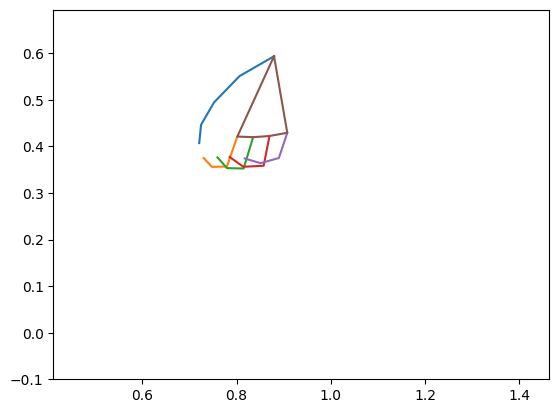

In [ ]:
#### VISUALIZE DATA

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

lips_m = np.nan_to_num(lips_3d[:,:,:,DIMC], copy=False)
lips_m[:,:,:,0] = lips_3d[:,:,:,0].max() - lips_3d[:,:,:,0]
left_m = np.nan_to_num(lefth_3d[:,:,:,DIMC], copy=False)
left_m[:,:,:,0] = lefth_3d[:,:,:,0].max() - lefth_3d[:,:,:,0]
pose_m = np.nan_to_num(pose_3d[:,:,:,DIMC], copy=False)
pose_m[:,:,:,0] = pose_3d[:,:,:,0].max() - pose_3d[:,:,:,0]
right_m = np.nan_to_num(righth_3d[:,:,:,DIMC], copy=False)
right_m[:,:,:,0] = righth_3d[:,:,:,0].max() - righth_3d[:,:,:,0]



# Functions to define landmark lines from the data
def get_hand_points(hand):
    x = [[hand[0,0],  hand[1,0],  hand[2,0],  hand[3,0], hand[4,0]], # Thumb
         [hand[5,0],  hand[6,0],  hand[7,0],  hand[8,0]], # Index
         [hand[9,0],  hand[10,0], hand[11,0], hand[12,0]], 
         [hand[13,0], hand[14,0], hand[15,0], hand[16,0]], 
         [hand[17,0], hand[18,0], hand[19,0], hand[20,0]], 
         [hand[0,0],  hand[5,0],  hand[9,0],  hand[13,0], hand[17,0], hand[0,0]]]

    y = [[hand[0,1],  hand[1,1],  hand[2,1],  hand[3,1], hand[4,1]], # Thumb
         [hand[5,1],  hand[6,1],  hand[7,1],  hand[8,1]], # Index
         [hand[9,1],  hand[10,1], hand[11,1], hand[12,1]], 
         [hand[13,1], hand[14,1], hand[15,1], hand[16,1]], 
         [hand[17,1], hand[18,1], hand[19,1], hand[20,1]], 
         [hand[0,1],  hand[5,1],  hand[9,1],  hand[13,1], hand[17,1], hand[0,1]]]

    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y



In [ ]:
# LEFT HAND
#vid = left_m[20000,:,:,:]
vid = lefth_3d[20000,:,:,:]

def animation_frame(v):
    lx, ly = get_hand_points(v)
    ax.clear()
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

xmin = vid[:,:,0].min() - 0.1
xmax = vid[:,:,0].max() + 0.1
ymin = vid[:,:,1].min() - 0.1
ymax = vid[:,:,1].max() + 0.1

fig, ax = plt.subplots()
(l,) = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=vid, interval=300)

HTML(animation.to_html5_video())

In [ ]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
print(f"The sign being shown here is: {train[train.path==f'{path_to_sign}'].sign.values[0]}")

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())

# Single Flow Model

In [ ]:
datx = np.concatenate((d1,d2,d3,d4), axis=1)
datx.shape

(94477, 4, 40)

In [ ]:
# SAVER
class ASLData(Dataset):
    def __init__(self, datx, datay):
        self.datax = datx
        self.datay = datay

    def __getitem__(self, index):
        return self.datax[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm1d(datx.shape[1]*datx.shape[2])
        self.dropout0 = nn.Dropout(p)
        
        self.layer1 = nn.Linear(datx.shape[1]*datx.shape[2], 512)
        self.batchnorm1 = nn.BatchNorm1d(512)

        self.layer2 = nn.Linear(512, 512)
        self.batchnorm2 = nn.BatchNorm1d(512)

        self.layerFC = nn.Linear(512, 250)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = self.flatten(x)
        # x = self.batchnorm0(x)
    
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layerFC(x)

        return x




In [ ]:
###############
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

EPOCHS = 40
BATCH_SIZE = 64
start_time = time.perf_counter()
print("DATAX SHAPE IN", datx.shape)

#datax = datax.reshape(datax.shape[0],datax.shape[1], -1) #.swapaxes(1,2)
print("DATAX SHAPE IN2", datx.shape)
datax = torch.tensor(datx)  # Convert to Torch Tensor

trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

train_data = ASLData(trainx, trainy)
valid_data = ASLData(testx, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

model = ASLModel(0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)  
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

# Save the pytorch model
py_model_path = f"{WORKING_DIR}/py_model.pt"
torch.save(model, py_model_path)

print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using CPU++++
DATAX SHAPE IN (94477, 4, 40)
DATAX SHAPE IN2 (94477, 4, 40)
DIM=3 FRAMES=16, FEAT=115
Epoch:0 > Train Loss: 2.8135, Train Acc: 0.3496
Epoch:0 > Val Loss: 1.9060, Val Acc: 0.5312
DIM=3 FRAMES=16, FEAT=115
Epoch:1 > Train Loss: 1.9440, Train Acc: 0.5136
Epoch:1 > Val Loss: 1.6431, Val Acc: 0.5890
DIM=3 FRAMES=16, FEAT=115
Epoch:2 > Train Loss: 1.6881, Train Acc: 0.5695
Epoch:2 > Val Loss: 1.4856, Val Acc: 0.6358
DIM=3 FRAMES=16, FEAT=115
Epoch:3 > Train Loss: 1.5130, Train Acc: 0.6087
Epoch:3 > Val Loss: 1.3907, Val Acc: 0.6559
DIM=3 FRAMES=16, FEAT=115
Epoch:4 > Train Loss: 1.3722, Train Acc: 0.6425
Epoch:4 > Val Loss: 1.3308, Val Acc: 0.6741
DIM=3 FRAMES=16, FEAT=115
Epoch:5 > Train Loss: 1.2620, Train Acc: 0.6663
Epoch:5 > Val Loss: 1.2895, Val Acc: 0.6830
DIM=3 FRAMES=16, FEAT=115
Epoch:6 > Train Loss: 1.1817, Train Acc: 0.6855
Epoch:6 > Val Loss: 1.2596, Val Acc: 0.6886
DIM=3 FRAMES=16, FEAT=115
Epoch:7 > Train Loss: 1.1132, Train Acc: 0.7026
Epoch:7 > Val Loss: 1

#tsLearn
https://tslearn.readthedocs.io/en/stable/quickstart.html 

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pts_hand =    [PRIM_HAND("THUMB_TIP"),
               PRIM_HAND("INDEX_FINGER_TIP"),
               PRIM_HAND("MIDDLE_FINGER_TIP"),
               PRIM_HAND("RING_FINGER_TIP"), 
               PRIM_HAND("PINKY_FINGER_TIP"),
               PRIM_HAND("THUMB_IP"),
               PRIM_HAND("INDEX_FINGER_PIP"),
               PRIM_HAND("MIDDLE_FINGER_PIP"),
               PRIM_HAND("RING_FINGER_PIP"), 
               PRIM_HAND("PINKY_FINGER_PIP")]




from tslearn.neighbors import KNeighborsTimeSeriesClassifier
dx = datax[:,:,PRIM_HAND("THUMB_TIP"),:]
print("dx in", dx.shape)
dx = datax.reshape(datax.shape[0], datax.shape[1], -1)
print("dx out", dx.shape)

trainx, testx, trainy, testy = train_test_split(dx, datay, test_size=0.15, random_state=42)

knn = KNeighborsTimeSeriesClassifier(n_neighbors=5)
knn.fit(trainx, trainy)

y_hat = knn.predict(testx)

knn.score(testx, testy)

dx in (94477, 16, 3)
dx out (94477, 16, 345)


KeyboardInterrupt: ignored

In [ ]:
y_hat = knn.predict()


KNeighborsTimeSeriesClassifier(n_neighbors=3)

#Random Forest

In [ ]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Split the data into training and test sets
trainx, testx, trainy, testy = train_test_split(datax.reshape(datax.shape[0], -1), datay, test_size=0.15, random_state=42)

rf = RandomForestClassifier()
rf.fit(trainx, trainy)

y_pred = rf.predict(testx)
accuracy = accuracy_score(testy, y_pred)
print("Accuracy:", accuracy)

#ROCKET

In [ ]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.1 MB/s eta 0:00:00


In [ ]:

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)


In [ ]:
# FILTER TO REDUCE DATASET SIZE 
datax = datax[datay < 20]
datay = datay[datay < 20]
print("DATAX", datax.shape, datay.shape)


DATAX (7528, 12, 40, 3) (7528,)


In [ ]:
# FIXED SIZE MODEL
#datax = np.nan_to_num(datax, copy=False)
datax = datax[:,:,-1]
datax = datax.swapaxes(1,2) # swap frame with data
trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(trainx)
X_train_transform = minirocket_multi.transform(trainx)

scaler = StandardScaler(with_mean=False)
X_train_scaled_transform = scaler.fit_transform(X_train_transform)

#classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier = SGDClassifier(loss='log')
classifier.fit(X_train_scaled_transform, trainy)

X_test_transform = minirocket_multi.transform(testx)
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, testy)


0.09646017699115045

#SAVED MULTI MODEL

In [ ]:
### MULTI MODEL SETUP
class ASLData(Dataset):
    def __init__(self,d1,d2,d3,d4,datay):
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.d4 = d4

        self.datay = datay

    def __getitem__(self, index):
        return self.d1[index, :], self.d2[index, :],self.d3[index, :],self.d4[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p)
        self.relu = nn.ReLU()

        L1OUT = 512  #1024 was ok
        L2OUT = 512
        self.layer_ph = nn.Linear(d1.shape[1]*d1.shape[2], L1OUT)
        self.batchnorm_ph = nn.BatchNorm1d(L1OUT)

        self.layer_sh = nn.Linear(d2.shape[1]*d2.shape[2], L1OUT)
        self.batchnorm_sh = nn.BatchNorm1d(L1OUT)

        self.layer_po = nn.Linear(d3.shape[1]*d3.shape[2], L1OUT)
        self.batchnorm_po = nn.BatchNorm1d(L1OUT)

        self.layer_li = nn.Linear(d4.shape[1]*d4.shape[2], L1OUT)
        self.batchnorm_li = nn.BatchNorm1d(L1OUT)

 
        self.layer1 = nn.Linear(4*L1OUT, L2OUT)
        self.batchnorm1 = nn.BatchNorm1d(L2OUT)

        self.layerFC = nn.Linear(L2OUT, 250)
 
        
    def forward(self, phand, shand, pose, lips):
        
        ph = self.flatten(phand)       
        ph = self.layer_ph(ph)
        ph = self.batchnorm_ph(ph)
        ph = self.relu(ph)
        ph = self.dropout(ph)

        sh = self.flatten(shand)       
        sh = self.layer_sh(sh)
        sh = self.batchnorm_sh(sh)
        sh = self.relu(sh)
        sh = self.dropout(sh)
       
        po = self.flatten(pose)       
        po = self.layer_po(po)
        po = self.batchnorm_po(po)
        po = self.relu(po)
        po = self.dropout(po)
        
        li = self.flatten(lips)       
        li = self.layer_li(li)
        li = self.batchnorm_li(li)
        li = self.relu(li)
        li = self.dropout(li)

        x = torch.cat((ph.view(ph.size(0), -1),
                       sh.view(sh.size(0), -1),
                       po.view(po.size(0), -1),
                       li.view(li.size(0), -1)), dim=1)
        
        # x = self.batchnorm0(x)
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layerFC(x)

        return x


In [ ]:
## MULT TRAINING
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

EPOCHS = 40
BATCH_SIZE = 64
start_time = time.perf_counter()
print("DATAX SHAPE IN", datax.shape)

#datax = datax.reshape(datax.shape[0],datax.shape[1], -1) #.swapaxes(1,2)
print("DATAX SHAPE IN2", datax.shape)
datax = torch.tensor(datax)  # Convert to Torch Tensor

traind1, testd1, traind2, testd2, traind3, tesdt3,traind4,testd4, trainy, testy = train_test_split(d1, d2, d3, d4, datay, test_size=0.15, random_state=42)

train_data = ASLData(traind1, traind2, traind3, traind4, trainy)
valid_data = ASLData(testd1, testd2, tesdt3, testd4, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

model = ASLModel(0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x1,x2,x3,x4,y in train_bar:
        x1 = torch.Tensor(x1).float().to(device)
        x2 = torch.Tensor(x2).float().to(device)
        x3 = torch.Tensor(x3).float().to(device)
        x4 = torch.Tensor(x4).float().to(device)

        y = torch.Tensor(y).long().to(device)  
        y_pred = model(x1,x2,x3,x4)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x1,x2,x3,x4,y in val_loader:
        x1 = torch.Tensor(x1).float().to(device)
        x2 = torch.Tensor(x2).float().to(device)
        x3 = torch.Tensor(x3).float().to(device)
        x4 = torch.Tensor(x4).float().to(device)
        y = torch.Tensor(y).long().to(device)
        
        with torch.no_grad():
            y_pred = model(x1,x2,x3,x4)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

# Save the pytorch model
py_model_path = f"{WORKING_DIR}/py_model.pt"
torch.save(model, py_model_path)

print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using CPU++++
DATAX SHAPE IN (94477, 16, 115, 3)
DATAX SHAPE IN2 (94477, 16, 115, 3)
DIM=3 FRAMES=16, FEAT=115
Epoch:0 > Train Loss: 3.2170, Train Acc: 0.2702
Epoch:0 > Val Loss: 2.5417, Val Acc: 0.3978


KeyboardInterrupt: ignored